# Risk Factor Backtesting - KS Test, Ruiz and Bunsoo methodology

**Introduction:<br>**
This notebook contains the implementation of the Ruiz and Bumsoo methodologies for backtesting Risk Factor distributions. Both are extentions of the KS-test (kolmogorov-Smirnov). The methodologies on which this notebook is based are taken from the following papers:
- "https://www.mocaxintelligence.com/wp-content/uploads/2016/02/iRuiz_Backtesting_counterparty_risk_models.pdf"  (Ignacio Ruiz, 2012)
- "https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3520973" (Bumsoo Kyung, 2020)
<br>

**Author:** <br>
This Notebook (implementation and analysis) is the work and property of Joshua KAJI, FRM. All Rights reserved. 

**Structure of the document:**<br>
The notebook is structured to facilitate comprehension of the methodology, both in terms of implementation and description.

**Table of Content:**
1) Summary of the methodologies
2) Building Ruiz and Bumsoo hypothesis tests <br>
    2.1)Simulate log-returns via Monte Carlo<br>
    2.2) Transform returns via Bumsoo<br>
    2.3) Implementation check : Compare autocorrelation of regular VS transformed (Bumsoo) returns<br>
    2.4) Illustration : Calculating the KS-distance for one scenario<br>
    2.5) Calculating Thresholds for the hypothesis tests<br>
3) Implementation check of the hypothesis test<br>
4) Outcome Analysis : comparing Type II errors of Ruiz vs Bumsoo







## 1) Summary of the methodologies

### KS-test statistic for non-overlapping returns, short horizons:

The Kolmogorov-Smirnov (KS) test is a non-parametric method used to determine whether a sample of observations follows a specified distribution. In the context of backtesting risk factors, the KS test is commonly applied to assess the goodness of fit between the observed distribution of returns and the theoretical distribution used for risk modeling (ie : the forcasted distribution). 

<u>Hypothesis test (KS-test):</u>
$$
\begin{align*}
H_0: \text{KS-distance} < \text{threshold}_{95\%} \quad \Leftrightarrow \quad \text{The model is correct}^{*}
\end{align*}
$$

Where: 
$$
\begin{align*}
\text{KS-distance} &= \text{dist}(\text{observed distribution}, H_0 \text{distribution}) \\
&= \text{dist}(\widehat{\text{CDF}}_{\text{observed}}, \text{CDF}_{H_0}) \\
&= \sup_{x \in \mathbb{R}} \left| \widehat{\text{CDF}}_{\text{observed }}(x) - \text{CDF}_{H_0}(x) \right| \\
&= \text{dist}(\widehat{\text{CDF}}_{\text{CDF}_{H_0}(observed)}, \text{CDF}_{\text{Unif}([0, 1])}) \\
&= \sup_{y \in [0, 1]} \left| \widehat{\text{CDF}}_{\text{CDF}_{H_0}(observed)}(y) - y \right|
\end{align*}
$$


\*  like any hypothesis test, if H0 is not rejected the conclusion NOT that H0 is true. It means, rather, that there is not enough evidence according to the test to reject H0 (with 95% confidence).

<u>Note:</u> In the above equations, "distribution $H_0$" refers the forecasted distribution.

### Ruiz methodology, overlapping returns: 

For longer horizons in backtesting, taking only independent observations (ie, non overlapping returns) is often impractical, as results in an insufficient number of data points to compute meaningful measures (eg: over a 5 year backtesting window, only 4 1-year log-returns can be extracted).

To address this, overlapping returns can be used to increase the number of observations within a limited backtesting window. However, this introduces a challenge: overlapping returns are autocorrelated, meaning the observations are no longer independent and identically distributed (iid). Consequently, the standard KS statistic is no longer valid for measuring the goodness of fit.

The Ruiz methodology addresses this issue by calculating via Monte Carlo simulations the critical thresholds. These thresholds are used to decide whether to reject or accept the fit of the observed data, accounting for the autocorrelation in overlapping returns.

<u>Hypothesis test (Ruiz):</u>
$$
\begin{align*}
H_0: \text{KS-distance} < \text{threshold}^{MC}_{95\%} 
\end{align*}
$$

The specificity of Ruiz lies in the calculation of $\text{threshold}^{MC}_{95\%}$ which is done via Monte Carlo. 

The problem with the Ruiz method is that the discriminatory power of the test is weak, particularly for longer horizons.

### Bumsoo methodology, removing autocorrelation of returns:

The Bumsoo methodology adds to the Ruiz methodology by transforming the log-returns such that auto correlation between consecutive returns are removed. This transformation must be applied to both the observed returns and the MC-generated returns to ensure symetry of treatment.  

<u>Hypothesis test (Bumsoo):</u>
$$
\begin{align*}
H_0: \text{KS-distance*} < \text{threshold}^{MC*}_{95\%} 
\end{align*}
$$

Where: 
$$
\begin{align*}
\text{KS-distance*} &= \text{dist}(\text{transformed observed distribution}, \text{tranformed H0 distribution}) \\
&= \sup_{y \in [0, 1]} \left| \widehat{\text{CDF}}_{\text{CDF}_{H_0}(\text{transformed observations})}(y) - y \right|
\end{align*}
$$

The same transformation is applied to the MC generated returns for the purpose of calculating $\text{threshold}^{MC*}_{95\%}$.

## 2) Building Ruiz and Bumsoo hypothesis tests 



### 2.1) Simulate log-returns via Monte Carlo

<u>Simulate paths via Monte Carlo (following H0 distribution):</u>

In [311]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jan 5 13:58:14 2025

@author: joshuakaji
"""
import numpy as np
from scipy.stats import ks_1samp, norm
from scipy.stats import binom_test
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.stats import binomtest
import warnings


def simulate_gbm(mu, sigma, S0, T, dt, n_paths):
    n_steps = int(T / dt)
    paths = np.zeros((n_paths, n_steps + 1))
    paths[:, 0] = S0
    for t in range(1, n_steps + 1):
        z = np.random.normal(size=n_paths)
        paths[:, t] = paths[:, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return paths


<Axes: title={'center': 'GBM (mu = 0% , sigma =  10%, 3 Years)'}>

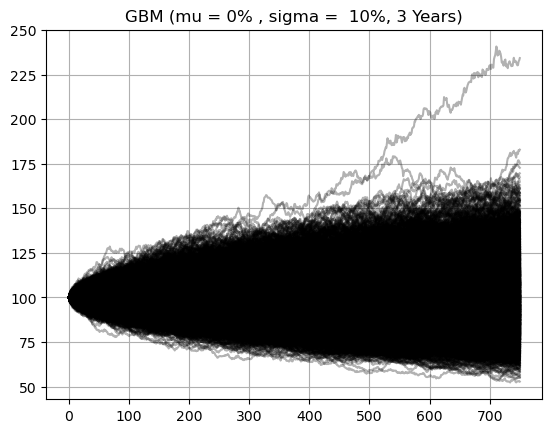

In [277]:
# example 
# Parameters
mu = 0.0      # Drift
sigma = 0.1    # Volatility
S0 = 100       # Initial price
T = 3.0        # Time horizon (5 year)
dt = 1/250      # Time step
n_paths = 5000 # Number of simulation paths
confidence_levels = [0.9, 0.95, 0.99]  # Confidence levels

paths = simulate_gbm(mu, sigma, S0, T, dt, n_paths)

sims = pd.DataFrame(paths).T
title = f"GBM (mu ={mu*100 : .0f}% , sigma = {sigma*100 : .0f}%, {T:.0f} Years)"
sims.plot(legend=False, color = 'black', alpha = 0.3, grid = True, title=title)

<u>Filter path for horizon and frequency + determine log-returns:</u>



In [278]:
hori = 125 # horizon such that R(t+hori) = S(t + hori) - S(t)
freq = 5  # samples are taken with timesteps t in [0, freq, 2*freq, ...]
log_returns = np.log(paths[:, hori:] /paths[:, 0:-hori])[:, ::freq]

### 2.2) Transform returns via Bumsoo

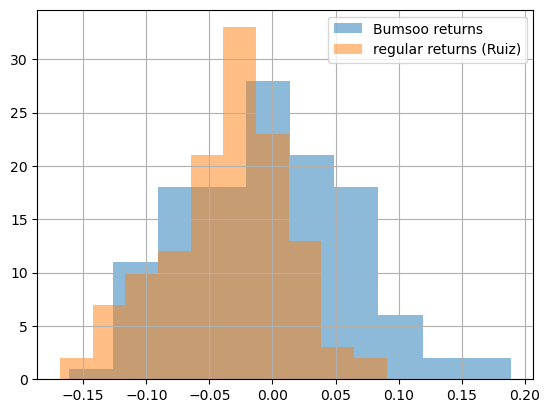

In [316]:
# autocorrelation between returns
corr = (hori - freq)/hori
drift = (mu - 0.5* sigma**2) * hori *dt
log_returns_bunsoo = drift + ((log_returns[:, 1:] - drift) - corr * ((log_returns[:, :-1] - drift)))/np.sqrt(1 - corr**2)

pd.DataFrame(log_returns_bunsoo).T.iloc[:, 1].hist(alpha=0.5, label="Bumsoo returns")
pd.DataFrame(log_returns).T.iloc[:, 1].hist(alpha=0.5, label="regular returns (Ruiz)")
plt.legend()
plt.show()


### 2.3) Implementation check : Compare autocorrelation of regular VS transformed (Bumsoo) returns
<u>Autocorrelation Closed forme formula</u>:

$$
\begin{align*}
\text{Autocorrelation (Regular)}: \quad & \rho_{\text{regular}} = \frac{\text{horizon} - \text{freq}}{\text{horizon}} \\[10pt]
\text{Autocorrelation (Bumsoo)}: \quad & \rho_{\text{Bumsoo}} = \frac{\text{freq}}{2 \cdot \text{horizon} - \text{freq}} \cdot \rho_{\text{regular}}
\end{align*}
$$

We calculate the autocorrelation of the Bunsoo (transformed) returns empirically and via the closed-form formula (proof in document).

We calculate the autocorrelation of the regular returns empirically and via the closed-form formula (proof in source document). 

<u>Note:</u> The closed formulas above highlight how the auto-correlation increases the more the returns overlap. This makes sense intuitively since the more overlap there is, the more common information is shared between consecutive returns. 

In [280]:
lrb = pd.DataFrame(log_returns_bunsoo).T
lr = pd.DataFrame(log_returns).T

print(f"autocorrelation of regular log-returns {lr.apply(lambda s : s.autocorr(lag=1)).mean()*100 : .2f}%")
print(f"autocorrelation of Bumsoo log-returns {lrb.apply(lambda s : s.autocorr(lag=1)).mean()*100 : .2f}%")

# closed forme formula of autocorelations 
theoretical_autocorrel_regular = (hori-freq)/hori
theoretical_autocorrel_Bumsoo = freq/(2*hori - freq) * theoretical_autocorrel_regular 
print(f"autocorrelation of regular log-returns (formula) {theoretical_autocorrel_regular*100 : .2f}%")

print(f"autocorrelation of Bumsoo log-returns (formula) {theoretical_autocorrel_Bumsoo*100 : .2f}%")

autocorrelation of regular log-returns  93.78%
autocorrelation of Bumsoo log-returns  1.65%
autocorrelation of regular log-returns (formula)  96.00%
autocorrelation of Bumsoo log-returns (formula)  1.96%


<u>Interpretation :</u>

The empirical auto correlation between regular log-returns and transformed are similar to the theoretical (closed-formula) ones. This reasures us that the implementation is correct. 

### 2.4) Illustration : Calculating the KS-distance for one scenario

In this section, we calculate the KS-distance for one scenario; the first of the MC scenarios generated. The PIT transform ($CDF_{H_0}$) is applied to each of the log returns of the scenario, yielding an equal number of p-values. The distributino of p-values is then compared against the unifrom distribution. When observations are iid (ie, non-overlapping returns), the p-values follow exactly a uniform distribution. In that case, the distribution of the KS-distances (ie, the distance between the distribution of p-values vs the uniform distribution) is known. 
However, when the assumptions of iid of observations are not verified, which is the case for overlapping returns, closed-formula thresholds are no longer valid. 

Instead, we construct these thresholds by simulating the KS-distance distribution via monte carlo. 
This means: 
- simulating Risk Factor processes via MC that verify H0
- for each simulation:
    - calculate log-returns according to the backtest horizon and the frequency of observations
    - applying PIT transformations ($PIT : x -> CDF_{Normal(drift, volatility))}(x)$ ) to the log returns to obtain p-values
    - calculating the distance between the p-value distribution and the $Uniform_{[0, 1]}$ distrbitution to obtain KS-distances
- The threshold is calculated as the percentile of the KS distance distribution (with chosen confidence level)

It is usefull to note that various thresholds can be determined from the simulated distribution of KS-distances. These thresholds can than be used to construct a traffic light-style test yielding more nuanced results; more specifically, with rejections of varying degree.


Scenario 0 :
	KS distance calculated (Ruiz) :  0.23
	KS distance calculated (Bumsoo) :  0.04
Scenario 1 :
	KS distance calculated (Ruiz) :  0.28
	KS distance calculated (Bumsoo) :  0.06
Scenario 2 :
	KS distance calculated (Ruiz) :  0.16
	KS distance calculated (Bumsoo) :  0.06


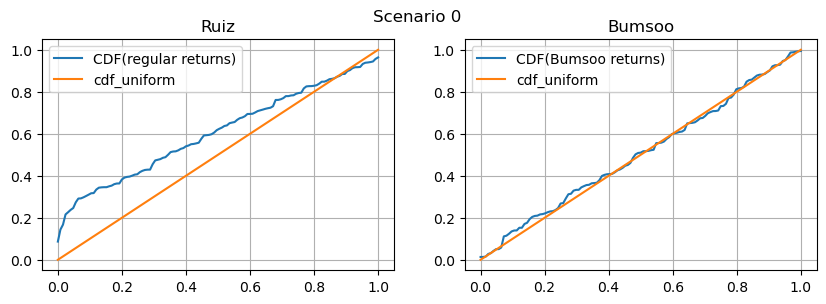

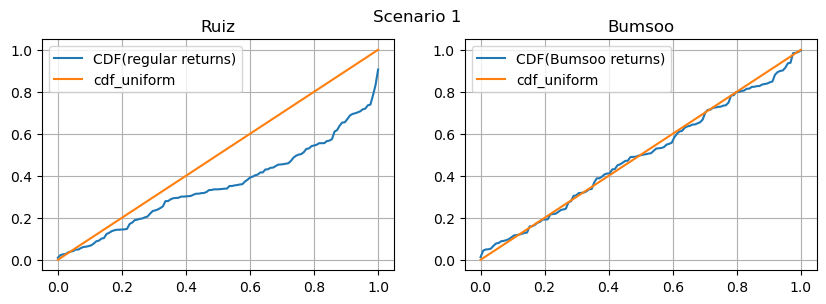

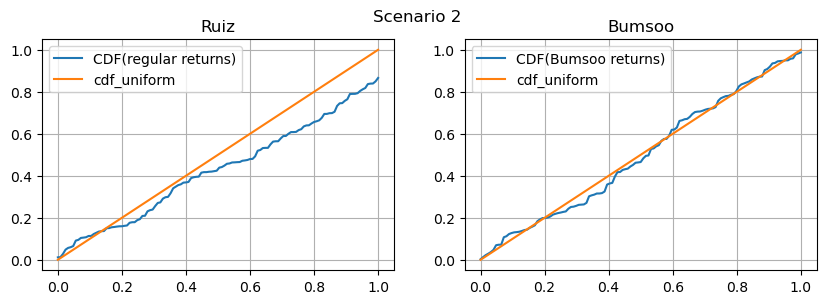

In [315]:
# Theoretical mean and standard deviation for one observation (log-return)
theoretical_mean = (mu - 0.5 * sigma**2) * dt * hori
theoretical_std = sigma * np.sqrt(dt * hori)

def theoretical_cdf(x):
    return norm.cdf((x - theoretical_mean) / theoretical_std)

# on this figure, we will plot illustrative KS-distance for regular returns (Ruiz) vs transformed returns (Bumsoo)
#fig, ax = plt.subplots(1, 2, figsize=(10, 5))

warnings.filterwarnings("ignore")
for s in range(0, 3):
    print(f"Scenario {s} :" )
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    lr_s0 = lr.loc[:, s] # scenario 0
    PIT = norm.cdf(lr_s0, loc = theoretical_mean, scale = theoretical_std)

    PIT.sort()
    cc = pd.DataFrame(data = [PIT, np.linspace(0, 1, len(PIT))]).T
    cc.index = np.linspace(0, 1, len(PIT))
    cc.columns = ["CDF(regular returns)", "cdf_uniform"]
    cc.plot(grid = True, ax = ax[0])
    ks_dist = abs(PIT - np.linspace(0, 1, len(PIT))).max()
    ax[0].set_title("Ruiz")
    print(f"\tKS distance calculated (Ruiz) : {ks_dist : .2f}" )


    lrb_s0 = lrb.loc[:, s] # scenario 0
    PIT = norm.cdf(lrb_s0, loc = theoretical_mean, scale = theoretical_std)

    PIT.sort()
    cc = pd.DataFrame(data = [PIT, np.linspace(0, 1, len(PIT))]).T
    cc.index = np.linspace(0, 1, len(PIT))
    cc.columns = ["CDF(Bumsoo returns)", "cdf_uniform"]
    cc.plot(grid = True, ax = ax[1])
    ks_dist = abs(PIT - np.linspace(0, 1, len(PIT))).max()
    ax[1].set_title("Bumsoo")
    print(f"\tKS distance calculated (Bumsoo) : {ks_dist : .2f}" )
    fig.suptitle(f"Scenario {s}")
    fig.show()

### 2.5) Calculating Thresholds for the hypothesis tests

Recall the the hypothesis test that we are constructing.

<u>Hypothesis test that is constructed (via MC):</u>
$$
\begin{align*}
H_0: \text{KS-distance} > \text{threshold}^{MC}_{95\%} 
\end{align*}
$$

<u>The confidence level allows us to control Type I error:</u>

The threshold, (above which we decide to reject the model) guaratees by contruction that the test will pass when H0 is true at the rate of the confidence level (95% here). This is refered to in statistics as the True Positives. The False Positives rate (1 - confidence level) gives us a type I error of 5%.

<u>High type II error in Ruiz methodology</u>:

The type II error is the rate of false negatives of the test. Ie, the rate at which the test accepts (does not reject) the observations that do not actually verify H0 (that do not follow the same distribution as the model). 

<u>Bumsoo methodology reduces Type II errors</u>:

In order to illustrate why the Bumsoo methodology is supperior to that of Ruiz, we may plot the Monte carlo distributions of KS distances using 1) regular returns and 2) the Bumsoo-transformed returns. 


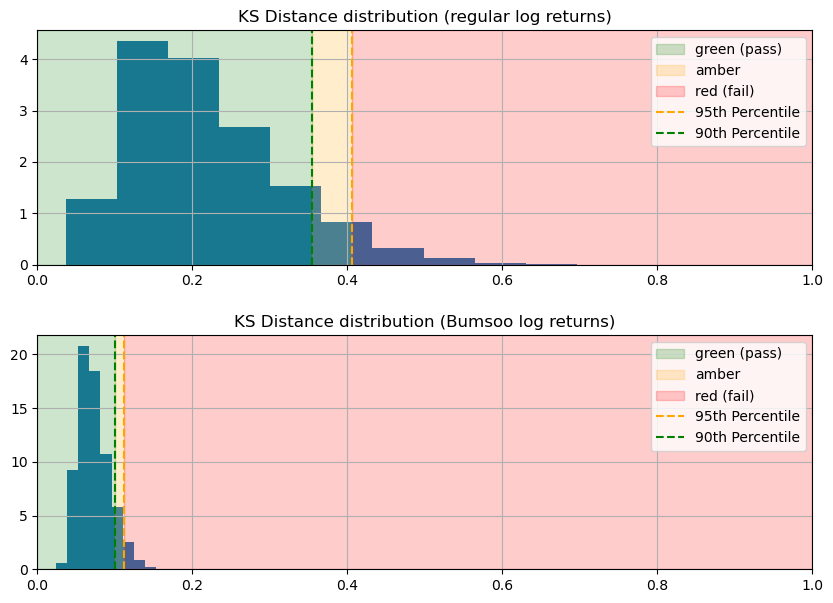

In [294]:
fig, ax = plt.subplots(2, 1, figsize=(10, 7))

################################################
## Regular log returns 
ks_statistics = []
for col in lr:
    lri = lr[col] # log returns of scenario
    # Compute KS statistic
    ks_stat = ks_1samp(lri, theoretical_cdf).statistic
    ks_statistics.append(ks_stat)

ks_statistics.sort()

# KS distribution 
ks_stat = pd.DataFrame(ks_statistics)
ks_stat.hist(density=True, ax=ax[0])
ax[0].set_title("KS Distance distribution (regular log returns)")
th_99, th_95, th_90 = ks_stat.quantile(0.99).values[0], ks_stat.quantile(0.95).values[0], ks_stat.quantile(0.90).values[0]

thresholds_ruiz = [th_90, th_95, th_99]

ax[0].set_xlim(0, 1)

# Highlight traffic light region 
ax[0].axvspan(0, th_90, color='green', alpha=0.2, label='green (pass)')
ax[0].axvspan(th_90, th_95, color='orange', alpha=0.2, label='amber')
ax[0].axvspan(th_95, 1, color='red', alpha=0.2, label='red (fail)')


#ax[0].axvline(th_99, color='r', linestyle='--', label='99th Percentile')
ax[0].axvline(th_95, color='orange', linestyle='--', label='95th Percentile')
ax[0].axvline(th_90, color='g', linestyle='--', label='90th Percentile')
ax[0].legend()


################################################
## Bumsoo/tranformed log returns
ks_statistics = []
for col in lrb:
    lri = lrb[col] # log returns of scenario
    # Compute KS statistic
    ks_stat = ks_1samp(lri, theoretical_cdf).statistic
    ks_statistics.append(ks_stat)

ks_statistics.sort()

# KS distribution 
ks_stat = pd.DataFrame(ks_statistics)
ks_stat.hist(density=True, ax=ax[1])
ax[1].set_title("KS Distance distribution (Bumsoo log returns)")
th_99, th_95, th_90 = ks_stat.quantile(0.99).values[0], ks_stat.quantile(0.95).values[0], ks_stat.quantile(0.90).values[0]

thresholds_bumsoo= [th_90, th_95, th_99]

ax[1].set_xlim(0, 1)

# Highlight traffic light region 
ax[1].axvspan(0, th_90, color='green', alpha=0.2, label='green (pass)')
ax[1].axvspan(th_90, th_95, color='orange', alpha=0.2, label='amber')
ax[1].axvspan(th_95, 1, color='red', alpha=0.2, label='red (fail)')


#ax[0].axvline(th_99, color='r', linestyle='--', label='99th Percentile')
ax[1].axvline(th_95, color='orange', linestyle='--', label='95th Percentile')
ax[1].axvline(th_90, color='g', linestyle='--', label='90th Percentile')
ax[1].legend()



<u>Explanation of the graphs </u>:

The first of the above graphs (topmost) is the distribution of KS-distances calculated via Monte Carlo using the regular returns. 
The second graph (bottommost) is the distribution of KS-distances calculated via Monte Carlo using the Bumsoo-transformed returns. 

<u>Green Zone </u>:
The green zones represent the non-rejection zone of the test with 90% confidence. This signals satifatory results. Indeed, in that case, we do not reject the model, not even with low confidence.

<u>Amber Zone </u>:
The amber zones represent the rejection of the test with 95% confidence. This signals that we reject the model, but only with low confidence. The results are not significant enought to reject the model at high confidence.

<u>Red Zone </u>:
The red zones represent the union of both:
- the non-rejection zone of the test with 95% confidence 
- the rejection of the test with 90% confidence. 
This signals unsatisfactory results. Indeed, in that case, we reject the model with a high degree of confidence.



## 3) Implementation check of the hypothesis test

In order to make sure that the thresholds are correctly calculated, we can simulated a sample of paths that verify H0 and apply the hypothesis test using the thresholds calculated prior. The sample of test results should follow a Bernouilli distribution with pass rate 0.95. To verify this, we can use a Binomial distribution test (since the sum of iid Bernouilli variables follows a binomial law).


In [296]:
# simulat new sample of RF paths that verify H0
n_sample = 100
paths2 = simulate_gbm(mu, sigma, S0, T, dt, n_sample)

# determine sample of Ruiz sample - regular log returns 
log_returns2 = np.log(paths2[:, hori:] /paths2[:, 0:-hori])[:, ::freq]

# determine sample of Bumsoo sample - transformed log-returns
corr = (hori - freq)/hori
drift = (mu - 0.5* sigma**2) * hori *dt

log_returns_bunsoo2 = drift + ((log_returns2[:, 1:] - drift) - corr * ((log_returns2[:, :-1] - drift)))/np.sqrt(1 - corr**2)
lrb2 = pd.DataFrame(log_returns_bunsoo2).T

# determine sample of p-values from Bumsoo sample
#print(lrb2)
ksd = lrb2.apply(lambda s : ks_1samp(s, theoretical_cdf).statistic , axis = 0)
h_test_result = ksd > thresholds_bumsoo[0]

# number of rejections of H0 observed from sample 
H0_reject_obs = h_test_result.sum()
result = binomtest(n=n_sample, k=H0_reject_obs, p = 1-0.9, alternative='two-sided')

print(f"p-value: {result.pvalue}")

# Confidence interval
confidence_level = 0.95  # 95% confidence level
ci = result.proportion_ci(confidence_level=confidence_level)

# Print the result
print(f"Observed proportion: {H0_reject_obs / n_sample}")
print(f"95% Confidence Interval: {ci.low:.3f} to {ci.high:.3f}")



p-value: 0.40422974916357673
Observed proportion: 0.07
95% Confidence Interval: 0.029 to 0.139


In the cell above, we apply the Binomial test to a sample of 100 hypothesis test results for the Bumsoo Hypothesis test. We check the test for the 90% confidence threshold only for illustration. 

The berniolli variables are constructed in the following way : 1 if pass, 0 if reject.

The confidence interval is based on the level of confidence we want to apply to our test; we chose a 95% confidence level in the example. 

<u>Note</u> : the confidence level of the binomial test (95%) is distinct from the confidence level of the Bumsoo Hypothesis test (which is 90%).

<u>Conclusion</u>: 
Since the observed proportion of pass is within the 95% confidence interval of a bernouilli distribution with a sample size of 100, we do not reject H0 (H0 = that the sample is in fact ${Bernouilli}(10\%)$-distributed).

This validates that our hypothesis test is well implemented.


## 4) Outcome Analysis : comparing Type II errors of Ruiz vs Bumsoo


Recall that the effectiveness of a hypothesis test depends on its Type I error rate and its Type II error. 

Type I error represents the rate of False Positives. As mentioned above, this is known (by construction) when we select the confidence level of the test. 

Type II error represents the rate of False Negatives. How often does the test accept H0 despite H0 not being true ? 

We first select a non-H0-conforming distribution for our test sample. In the example bellow we use a sample where the volatility is 5% higher (absolute shock) than the volatility parametor that the hypothesis-test tests for.   


In [298]:
# simulat new sample of RF paths that verify H0
n_sample = 1000
paths2 = simulate_gbm(mu, sigma + 0.05, S0, T, dt, n_sample)

# determine sample of Ruiz sample - regular log returns 
log_returns2 = np.log(paths2[:, hori:] /paths2[:, 0:-hori])[:, ::freq]

# determine sample of Bumsoo sample - transformed log-returns
corr = (hori - freq)/hori
drift = (mu - 0.5* sigma**2) * hori *dt
log_returns_bunsoo2 = drift + ((log_returns2[:, 1:] - drift) - corr * ((log_returns2[:, :-1] - drift)))/np.sqrt(1 - corr**2)
lrb2 = pd.DataFrame(log_returns_bunsoo2).T
ksd_bumsoo = lrb2.apply(lambda s : ks_1samp(s, theoretical_cdf).statistic , axis = 0)

################################################
## TYPE II error - Ruiz
# number of rejections of H0 observed from sample 
lr2 = pd.DataFrame(log_returns2).T
ksd_ruiz = lr2.apply(lambda s : ks_1samp(s, theoretical_cdf).statistic , axis = 0)

FN = (ksd_ruiz < thresholds_ruiz[0]).sum() # False Negative: wrongly accepts 
TP = (ksd_ruiz > thresholds_ruiz[0]).sum() # True Positives: rightly rejects 


# Type II error 
type2error = FN/(FN + TP)


print(f"Type II error (Ruiz) : {type2error*100 : .1f}%")

################################################
## TYPE II error - Bumsoo

# number of rejections of H0 observed from sample 
FN = (ksd_bumsoo < thresholds_bumsoo[0]).sum() # False Negative: wrongly accepts 
TP = (ksd_bumsoo > thresholds_bumsoo[0]).sum() # True Positives: rightly rejects 

# Type II error 
type2error = FN/(FN + TP)

print(f"Type II error (Bumsoo) : {type2error*100 : .1f}%")



Type II error (Ruiz) :  79.9%
Type II error (Bumsoo) :  6.8%



<u>Interpretation </u>:

The above results illustrate the increased discriminatory power of the Bumsoo method compared to Ruiz. Indeed, the Type II error in the Ruiz methodology is above 50% whilst that of the Bumsoo methodology is under 10%.

This means that we are more likely to rightly reject the hypothesis when the model is false. 

<u>Conclusion:</u> 

Bumsoo method has all the benefits of Ruiz methodology with the added benefit of significantly improving the type II error. 